In [7]:
using Pkg
# Pkg.update()
Pkg.instantiate()

using DevCommunities
using DataFrames, CSV
using SimpleHypergraphs
using Plots
using Graphs


In [8]:
####### Utility functions #######

function my_aggregator(p)
    result = Vector{eltype(p)}()
    for i = 1:length(p)
        push!(result, p[i])
    end
    result
end

function index(id)
    global hc
    global counter_id
    if !haskey(hc, id)
        hc[id] = counter_id
        counter_id += 1
    end
    return hc[id]
end

function community_detection(hg)
    
    b = SimpleHypergraphs.BipartiteView(hg)
    cc = connected_components(b)
    comm_sizes = [length(comm) for comm in cc]
    isolated_components = []
    # sort cc by length
    cc = sort(cc, by=length, rev=true)

    for comp in cc[2:length(cc)]
        append!(isolated_components, comp)
    end

    hg_no_isolated = deepcopy(hg)

    for v in Iterators.reverse(isolated_components)
        v > nhv(hg) && continue
        remove_vertex!(hg_no_isolated, Int(v))
    end

    hyperedges = [e for e in 1:nhe(hg_no_isolated) if length(getvertices(hg_no_isolated, e)) == 0]

    # remove empty hyperedges
    for he in Iterators.reverse(hyperedges)
        remove_hyperedge!(hg_no_isolated, he)
    end

    for he in Iterators.reverse(1:nhe(hg_no_isolated))
        for v in Iterators.reverse(collect(keys(getvertices(hg_no_isolated, he))))
            if v > nhv(hg_no_isolated)
                remove_hyperedge!(hg_no_isolated, he)
                break
            end
        end
    end

    # prune because i lose some vertices # rip heroes
    prune_hypergraph!(hg_no_isolated)
    cflp = CFLabelPropagationFinder(100, 1234)
    c = myfindcommunities(hg_no_isolated, cflp)
    return c
end

function my_pruning(hg)
    
    b = SimpleHypergraphs.BipartiteView(hg)
    cc = connected_components(b)
    comm_sizes = [length(comm) for comm in cc]
    isolated_components = []
    # sort cc by length
    cc = sort(cc, by=length, rev=true)

    for comp in cc[2:length(cc)]
        append!(isolated_components, comp)
    end

    hg_no_isolated = deepcopy(hg)

    for v in Iterators.reverse(isolated_components)
        v > nhv(hg) && continue
        remove_vertex!(hg_no_isolated, Int(v))
    end

    hyperedges = [e for e in 1:nhe(hg_no_isolated) if length(getvertices(hg_no_isolated, e)) == 0]

    # remove empty hyperedges
    for he in Iterators.reverse(hyperedges)
        remove_hyperedge!(hg_no_isolated, he)
    end

    for he in Iterators.reverse(1:nhe(hg_no_isolated))
        for v in Iterators.reverse(collect(keys(getvertices(hg_no_isolated, he))))
            if v > nhv(hg_no_isolated)
                remove_hyperedge!(hg_no_isolated, he)
                break
            end
        end
    end

    # prune because i lose some vertices # rip heroes
    prune_hypergraph!(hg_no_isolated)
    return hg_no_isolated
end

my_pruning (generic function with 1 method)

In [9]:
my_tags = ["rust" "elixir" "clojure" "typescript" "julia" "python" "delphi" "go" "sql" "c#" "kotlin" "swift" "dart" "html" "solidity" "javascript" "f#" "bash" "lisp" "apl"]
# my_tags = sort(my_tags)
df = DataFrame(CSV.File("/Users/ddevin/Documents/vscode/DevCommunities/so_data/2023-07-14_11-53-29/so_data_clean.csv"))
first(df, 5)

save_info = false

false

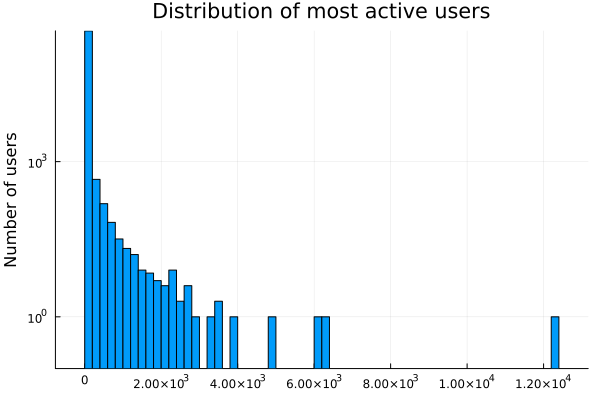

In [10]:
most_active_users = Dict()
for row in eachrow(df)
    if !haskey(most_active_users, row.new_id)
        most_active_users[row.new_id] = 0
    end
    most_active_users[row.new_id] += 1
end
histogram(collect(values(most_active_users)), bins=100, yscale=:log10, ylabel="Number of users", title="Distribution of most active users", legend=false)


In [ ]:
occurs_users = Dict()
for x in most_active_users
    if !haskey(occurs_users, x[2])
        occurs_users[x[2]] = 0
    end
    occurs_users[x[2]] += 1
end
sort(collect(occurs_users), by=x->x[1], rev=true)

# remove users with less than 2 occurances from population
df_1 = DataFrame()
for row in eachrow(df)
    if most_active_users[row.new_id] < 2
        continue
    end
    push!(df_1, row)
end
first(df_1, 5)

In [ ]:
population_filtered = combine(groupby(df_1, :question_id), 
        :new_id => Base.vect∘my_aggregator => :custom_arr,
        :tags => Base.vect∘my_aggregator => :tags,
        :q_new_id => Base.vect∘my_aggregator => :q_custom_arr,
        )

# remove lines with custom_arr of length 1
population_filtered = population_filtered[findall(x->length(x) > 1, population_filtered.custom_arr), :]

# population.tags = [unique(x) for x in population.tags]
population_filtered.tags = [unique(x) for x in population_filtered.tags]

population = population_filtered
new_tags = []
for row in eachrow(population)
    found = false
    my_new_tags = []
    for x in row.tags
        for tag in my_tags
            if occursin(tag, x)
                # push!(a, row.custom_arr)
                push!(my_new_tags, tag)
                found = true
            elseif tag == "go"
                if occursin("|go", x) || occursin("go|", x) || x == "go"
                    # push!(a, row.custom_arr)
                    push!(my_new_tags, tag)
                    found = true
                end
            end
        end
        if !found
            # # push!(a, row.custom_arr)
            push!(my_new_tags, "other")
            # found = true
        end
    end
    push!(new_tags, my_new_tags)
end

population[!, :tags2] = new_tags

In [ ]:
population = select(population, Not(:tags))
# here population has
user_x_tag = population

# user_x_tag
my_map = Dict()
for tag in my_tags
    my_map[tag] = []
end

# one hg for each tag
hgs = []

for tag in my_tags
    nodes = Dict{Int,Int}()
    nodes_per_edge = Dict{Int,Vector{Int}}()
    # Bool value of vertex, String value of meta info on vertex, String value of meta info on edge
    hg = Hypergraph{Bool, String, Vector{Any}}(0,0)
    for row in eachrow(user_x_tag)
        if tag in row.tags2
            vs = []
            for x in row.custom_arr
                if !haskey(nodes, x)
                    v_id = SimpleHypergraphs.add_vertex!(hg)
                    push!(nodes, x=>v_id)
                    # set_vertex_meta!(hg, s, v_id)
                end
                push!(vs, x)
            end
            for x in row.q_custom_arr
                if !haskey(nodes, x)
                    v_id = SimpleHypergraphs.add_vertex!(hg)
                    push!(nodes, x=>v_id)
                    # set_vertex_meta!(hg, s, v_id)
                end
                push!(vs, x)
            end
            vs = unique(vs)
            # add he
            vertices = Dict{Int, Bool}(nodes[v] => true for v in vs)
            he_id = SimpleHypergraphs.add_hyperedge!(hg; vertices = vertices)
            SimpleHypergraphs.set_hyperedge_meta!(hg, row.tags2, he_id)
            push!(nodes_per_edge, he_id => vs) 
        end
    end

    ##################
    push!(hgs, hg)
end

hgs_filtered = []
for hg in hgs
    ccount += 1
    hg_filtered = my_pruning(hg)
    # remove vertex with degree < 3
    for v in Iterators.reverse(1:nhv(hg_filtered))
        if length(gethyperedges(hg_filtered, v)) < 2
            remove_vertex!(hg_filtered, v)
        end
    end
    # remove hyperedges with only one vertex
    for he in Iterators.reverse(1:nhe(hg_filtered))
        if length(getvertices(hg_filtered, he)) < 2
            remove_hyperedge!(hg_filtered, he)
        end
    end
    prune_hypergraph!(hg_filtered)
    push!(hgs_filtered, hg_filtered)
end


counter = 1
if save_info
    for hg in hgs_filtered
        s = my_tags[counter]
        hg_save("./hgsFilterNew/$s", hg)
        counter += 1
    end
end

In [12]:
# Nodes,Edges,Avg.Degree, Density Avg.,Clustering, C. C.,Comm., Mod.
dir = "../../hgsFilterNew"

# df_info = DataFrame()
# # add name of dataset, number of nodes, number of edges, density, clustering, number of connected components, number of communities
# df_info = DataFrame(dataset=String[], nodes=Int64[], edges=Int64[], density=Float64[], clustering=Float64[], connected_components=Int64[], communities=Int64[])
# write header "dataset, nodes, edges" of csv
# header = ["dataset", "# nodes", "# edges", "density", "clustering", "# connected_components", "# communities"]

for s=2:3
    df_info = DataFrame()
    df_info = DataFrame(dataset=String[], nodes=Int64[], edges=Int64[], density=Float64[], clustering=Float64[], connected_components=Int64[], communities=Int64[])
    for file in readdir(dir)
        if endswith(file, ".hg")
            hg = build_hg("/Users/ddevin/Documents/vscode/DevCommunities/hgsFilterNew/"*file)
            hg = hg[1]
            A = SimpleHypergraphs.adjacency_matrix(hg; s=s)
            println("build matrix for "*file)
            flush(stdout)
            G = Graphs.SimpleGraph(A)
            # bc = Graphs.betweenness_centrality(G)
            nn = nhv(hg)
            ne = nhe(hg)
            ccs = SimpleHypergraphs.get_connected_components(hg)
            cc = length(ccs)
            # comms = community_detection(hg)
            cflp = CFLabelPropagationFinder(100, 1234)
            comms = myfindcommunities(hg, cflp)
            comm = length(comms[1])
            density = Graphs.density(G)
            clustering = Graphs.global_clustering_coefficient(G)
            # remove .hg from file
            file = file[1:length(file)-3]
            push!(df_info, [file, nn, ne, density, clustering, cc, comm])
            println([file, nn, ne, density, clustering, cc, comm])
            flush(stdout)
        end
        # first(df_info,1)
        flush(stdout)
    end
    CSV.write("/Users/ddevin/Documents/vscode/DevCommunities/src/notebook/info_s"*string(s)*".csv", df_info)
end

# for file in readdir(dir)
#     if endswith(file, ".hg")
#         hg = build_hg("/Users/ddevin/Documents/vscode/DevCommunities/hgsFilter/"*file)
#         hg = hg[1]
#         nn = nhv(hg)
#         ne = nhe(hg)
#         ccs = SimpleHypergraphs.get_connected_components(hg)
#         cc = length(ccs)
#         comms = community_detection(hg)
#         comm = length(comms[1])
#         b = BipartiteView(hg)
#         bipartite_graph = Graphs.SimpleGraph(b)
#         density = Graphs.density(bipartite_graph)
#         clustering = Graphs.global_clustering_coefficient(bipartite_graph)
#         # remove .hg from file
#         file = file[1:length(file)-3]
#         push!(df_info, [file, nn, ne, density, clustering, cc, comm])
#     end
# end   
# println(df_info)
# flush(stdout)
# CSV.write("/Users/ddevin/Documents/vscode/DevCommunities/src/notebook/infoBipartite.csv", df_info)



build matrix for apl.hg


Any["apl", 4, 5, 0.3333333333333333, 1.0, 2, 2]


build matrix for bash.hg


Any["bash", 1796, 4670, 0.0009615921484450124, 0.2674708818635607, 11, 510]


build matrix for c#.hg


Any["c#", 11390, 17278, 2.4360027014961605e-5, 0.015125005755329435, 121, 5547]


build matrix for clojure.hg


Any["clojure", 137, 288, 0.012881064834693002, 0.14961139896373057, 1, 34]


build matrix for dart.hg


Any["dart", 5956, 7977, 4.054361144897454e-5, 0.011846781624325392, 27, 2655]


build matrix for delphi.hg


Any["delphi", 216, 363, 0.0030146425495262705, 0.03776978417266187, 2, 101]


build matrix for elixir.hg


Any["elixir", 79, 151, 0.013631937682570594, 0.08132530120481928, 1, 36]


build matrix for f#.hg


Any["f#", 159, 284, 0.007403869118700741, 0.14347826086956522, 2, 34]


build matrix for go.hg


Any["go", 6369, 7929, 4.142237328896011e-5, 0.031543274244004174, 213, 3080]


build matrix for html.hg


Any["html", 20481, 24985, 6.999627703725404e-6, 0.016012469888054413, 359, 9345]


In [ ]:
if save_info
    dir = "./hgsFilter"
    for file in readdir(dir)
        if !endswith(file, ".hg")
            # println(file)
            s = "././hgsFilter/"*file
            # make a copy of the file
            run(`cp $s $s.copy`)
            # # substitue in each line "=true" with ","
            run(`sed -i '' 's/=true/,/g' $s`)
            # # remove first line
            run(`sed -i '' '1d' $s`)
            # # hash and rewriting id
            run(`python3 ./src/experiments/rewriteCC.py $s`)
        end
    end
end